Image Classification with Neural Nets

In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

overall test-set accuracy, measured however you think is appropriate
show some of the example images from the test set, together with your model's predicted classes.
a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).
I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

In [25]:
import time
import zipfile
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Path to your ZIP file
zip_path = r'C:\Users\Kimble\Downloads\STA380-master.zip'

# Directory to extract the contents of the ZIP file
extract_dir = r'C:\Users\Kimble\Downloads\STA380-master-extracted'

# Path within the extracted files where the images are located
image_dir = os.path.join(extract_dir, 'STA380-master', 'data', 'EuroSAT_RGB')

# Start timing
start_time = time.time()

# Step 1: Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Step 2: Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Step 3: Define your image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Step 4: Use ImageFolder to load the dataset
dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# Step 5: Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

# Stop timing
end_time = time.time()
print(f"Time taken to prepare dataset: {end_time - start_time} seconds")

# Check the dataset
print(f"Number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")

# Example: Accessing one batch of images and labels
for images, labels in dataloader:
    print(f"Batch size: {images.size()}")
    print(f"Labels: {labels}")
    break  # Just to demonstrate, you can remove this break to process all batches


Time taken to prepare dataset: 20.176546096801758 seconds
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Batch size: torch.Size([64, 3, 128, 128])
Labels: tensor([9, 8, 1, 8, 0, 7, 1, 6, 0, 1, 1, 0, 4, 7, 4, 3, 8, 7, 8, 0, 6, 9, 5, 3,
        5, 9, 0, 7, 0, 7, 7, 9, 0, 3, 7, 7, 1, 7, 5, 7, 5, 2, 9, 8, 2, 5, 0, 8,
        4, 7, 2, 3, 0, 0, 1, 3, 0, 6, 8, 8, 9, 4, 7, 1])


In [33]:
import torch
import subprocess
import sys
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
from torch.utils.data import random_split

# Suppose you want to split 80% for training and 20% for testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Now create DataLoaders for train and test sets
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [42]:
# Let's define a simple CNN to classify digits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(246016, 128)   #Have to calculate heigh and width based of previous layers  def calculate_output_size(input_size, kernel_size, stride=1, padding=0):       return ((input_size - kernel_size + 2 * padding) // stride) + 1
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=246016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [43]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [46]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = .001)

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}')

Epoch 1, Loss: 0.6003
Epoch 2, Loss: 0.4242
Epoch 3, Loss: 0.3209
Epoch 4, Loss: 0.2369
Epoch 5, Loss: 0.1678


Test Loss: 0.7784, Test Accuracy: 81.22%


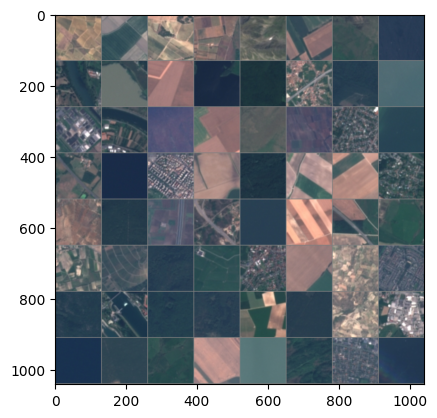

Predicted:  6 0 6 6
GroundTruth:  6 0 6 6


In [47]:
# Evaluate the model on the test set
net.eval()  # Set the network in evaluation mode
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(testloader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Visualize predictions on some test images
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predict on the test images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show images with predicted and true labels
imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join(f'{predicted[j].item()}' for j in range(4)))
print('GroundTruth: ', ' '.join(f'{labels[j].item()}' for j in range(4)))

Test Loss: 0.7784, Test Accuracy: 81.22%


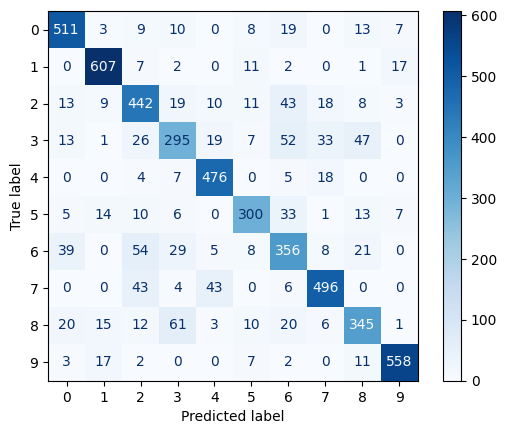

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test set
net.eval()  # Set the network in evaluation mode
correct = 0
total = 0
test_loss = 0.0

all_labels = []
all_preds = []

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(testloader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()